# 5. Single Output Model
---

In this notebook, we implement a model with a single output with multiple class.

## Import Libraries

In [135]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import time
from os import path
import sys
sys.path.append("../src")
from utils import destination

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [11]:
DATA_LIST = "../HARRISON/1116025023_data_list_aug.txt"
TAG_LIST = "../HARRISON/1116025023_tag_list_aug.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None,skip_blank_lines=False).fillna("")
hashtag["labels"] = hashtag["labels"].apply(lambda x: x.split(" "))

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
# filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target = shuffle(target, random_state=42)
target.head(5)

,filename,labels
0,school_image_1014.jpg,"[big, boy, love, day, school, like, great, nic..."
1,school_image_298.jpg,"[school, design, work, teacher, college, stude..."
2,tired_image_1900.jpg,"[depression, depressed, tired, beautiful, smil..."
3,smile_image_878.jpg,"[vsco, vscocam]"
4,school_image_853.jpg,"[happy, healthy, baby, kid, cooking, healthyfo..."


In [18]:
# Read hashtags
with open("../model/hashtags.txt") as f:
    # Read tag_list
    hashtags = f.read().split('\n')
hashtags = hashtags[:-1]

num_images = target.shape[0]
num_hashtags = len(hashtags)

print(f"Number of images: {num_images}")
print(f"Number of hashtags: {num_hashtags}")

Number of images: 86074
Number of hashtags: 997


## Prepare Images

In [21]:
IMAGE_DIR = "../HARRISON/images"

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# Use these values to split data into train, val, and test
train_idx = int(num_images * .70)
val_idx = int(num_images * .90)

train_generator = datagen.flow_from_dataframe(
    dataframe=target[:train_idx],
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes=hashtags,
    target_size=(100,100))

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=target[train_idx:val_idx],
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes=hashtags,
    target_size=(100,100))

test_generator = test_datagen.flow_from_dataframe(
    dataframe=target[val_idx:],
    directory=IMAGE_DIR,
    x_col="filename",
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(100,100))

Found 60222 validated image filenames belonging to 997 classes.
Found 17058 validated image filenames belonging to 997 classes.
Found 8608 validated image filenames.


## Build a Model
### 1. Multiple Output Nodes

In [27]:
# Define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_hashtags, activation='sigmoid'))

# Compile model
model.compile(
    optimizers.rmsprop(lr=0.0001, decay=1e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"])

# Show model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 49, 49, 64)       

## Fitting the Model

In [35]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

start_time = time.time()
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10,
    verbose=2)
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/10
 - 1292s - loss: 0.0877 - accuracy: 0.9788 - val_loss: 0.0815 - val_accuracy: 0.9790
Epoch 2/10
 - 1283s - loss: 0.0763 - accuracy: 0.9821 - val_loss: 0.0922 - val_accuracy: 0.9790
Epoch 3/10
 - 1309s - loss: 0.0754 - accuracy: 0.9821 - val_loss: 0.0850 - val_accuracy: 0.9790
Epoch 4/10
 - 1280s - loss: 0.0750 - accuracy: 0.9821 - val_loss: 0.0909 - val_accuracy: 0.9790
Epoch 5/10
 - 1278s - loss: 0.0746 - accuracy: 0.9821 - val_loss: 0.0943 - val_accuracy: 0.9790
Epoch 6/10
 - 1278s - loss: 0.0743 - accuracy: 0.9821 - val_loss: 0.0957 - val_accuracy: 0.9789
Epoch 7/10
 - 1278s - loss: 0.0741 - accuracy: 0.9821 - val_loss: 0.0831 - val_accuracy: 0.9790
Epoch 8/10
 - 1294s - loss: 0.0739 - accuracy: 0.9821 - val_loss: 0.1033 - val_accuracy: 0.9790
Epoch 9/10
 - 1294s - loss: 0.0737 - accuracy: 0.9821 - val_loss: 0.0878 - val_accuracy: 0.9789
Epoch 10/10
 - 1275s - loss: 0.0735 - accuracy: 0.9821 - val_loss: 0.0972 - val_accuracy: 0.9789


In [36]:
# Save model for future use
root = os.path.join("..", "model")
model.save(destination(root, "keras_model_5_mlsol"))

## Show Learning History

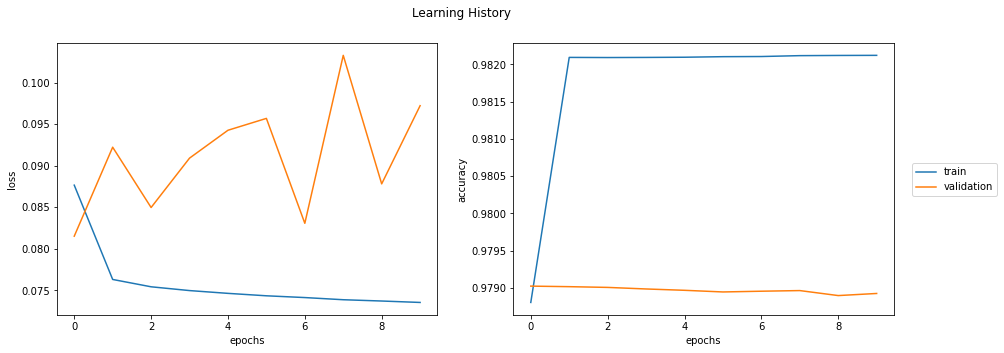

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
metric = ["loss", "accuracy"]

for idx in range(len(metric)):
    axs[idx].plot(history.history[metric[idx]], label="train")
    axs[idx].plot(history.history[f"val_{metric[idx]}"], label="validation")
    axs[idx].set(ylabel=metric[idx], xlabel="epochs")

fig.suptitle("Learning History")
plt.legend(loc="center right", bbox_to_anchor=(0,0,1,1),bbox_transform=plt.gcf().transFigure)

plt.show()

## Prediction

In [51]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

8608/8608 [==============================] - 117s 14ms/step


In [73]:
predictions = pred.astype(int)
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=hashtags)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+hashtags
results=results[ordered_cols]#To

In [163]:
def get_conf(row: list) -> dict:
    # Get hashtags with confidence
    keys = np.array(hashtags)[np.argwhere(row>0).flatten()]
    values = row[np.where(row>0)]
    
    # Sort the result 
    idx = values.argsort()[::-1]
    values = values[idx]
    keys = keys[idx]
    dict(zip(keys, values))

    return dict(zip(keys, values))

In [164]:
# Zscore normalization
normalized = (pred - pred.mean())/pred.std()
abv3std = np.where(normalized>3, normalized, 0)

# Get lists of hashtags
y_pred = pd.concat([
    pd.Series(test_generator.filenames, name="filename"),
    pd.Series([get_conf(row) for row in abv3std], name="y_pred")],
    axis=1)

y_true = target[target["filename"].isin(y_pred["filename"])][["filename", "labels"]]
y_true.rename(columns={"labels": 'y_true'}, inplace=True)

results = pd.merge(y_true, y_pred, left_on="filename", right_on="filename")
results.head()

,filename,y_true,y_pred
0,aug_20083.jpg,[loveyou],"{'mother': 7.6952963, 'wonderful': 7.046368, '..."
1,aug_20084.jpg,"[awesome, nice]","{'wonderful': 5.742683, 'purple': 5.411249, 'b..."
2,aug_20085.jpg,"[america, australia, boyfriend, brother, canad...","{'mother': 11.454558, 'cousin': 7.7483716, 'da..."
3,aug_20086.jpg,"[brazil, colombia, instafood, instalove, insta...","{'wonderful': 5.6801777, 'beach': 5.131941, 'o..."
4,aug_20087.jpg,"[alternative, boho, bored, crazy, depressed, e...","{'wonderful': 6.611362, 'blue': 5.627577, 'mot..."


## Some of the Pictures with predicted hashtags
Only 10 of the predicted hashtags are shown with the pictures.

In [192]:
## Manually Check Some of the Results...
import ipyplot
from heapq import nlargest

paths = list(results.filename.apply(lambda x: f"../HARRISON/images/{x}"))
labels = [[f"{key}({d[key]:.4f})" for key in nlargest(10, d, key=d.get)] for d in results["y_pred"]]

ipyplot.plot_images(paths, labels)